# Ship roll-decay simulation
> This is a short introduction to how a ship roll-decay test can be simulated.

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [roll-decay,simulation]
- image: https://raw.githubusercontent.com/martinlarsalbert/rolldecay/master/roll-decay-logo.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import warnings
warnings.filterwarnings("ignore")

## Roll damping

A systems ability to damp reconance motions can be crucial as in the case of the Tacoma-narrows-bridge-collapse:
![](https://upload.wikimedia.org/wikipedia/commons/4/4a/Tacoma-narrows-bridge-collapse.jpg)

<iframe width="560" height="315" src="https://www.youtube.com/embed/j-zczJXSxnw?start=20" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Resonance phenomena can also occur for ships, where for instance something called parametric roll can happen as can be seen in this video:

<iframe width="560" height="315" src="https://www.youtube.com/embed/7PyJj_oPdyg?start=29" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

Having enough roll damping is one way to deal with this problem.

## Ship roll-decay test
One way to determine the roll damping is to conduct a so called Roll-decay test. This test is conducted by giving the ship an initial roll angle and then observing the resulting oscillation. The oscillation motion will decrease with time due to energy losses from friction with the water and other things such as wave and eddy generation. Here is an example of a roll decay model test:

<iframe width="560" height="315" src="https://www.youtube.com/embed/gN123b8gM-o" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive

## Simulation
### Drop simulation
Newtons 2nd law can be used to predict the resulting motion from forces:
$$F=m \cdot a$$
so we want to determine acceleration $a$ which can then be integrated to get the velocity and position to describe the motion.

In [3]:
def calculate_acceleration(F,m):
    a = F/m
    return a

Lets simulate a 1 kg object falling without any drag. 
It can be done by:
1. calculate acceleration
2. calculate the velocity by adding acceleration
3. calculate the position by adding the velocity

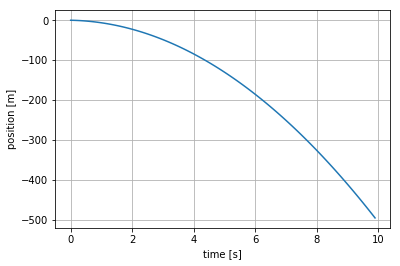

In [38]:
dt = 1/10
ts = np.arange(0,10,dt)

g=9.81
F=-g
m=1
velocity=0.0  # initial velocity
position=0.0  # initial position
positions=[]
for n in range(len(ts)):
    
    acceleration = calculate_acceleration(F=F, m=m)
    velocity = velocity + acceleration*dt
    position = position + velocity*dt
    positions.append(position)
positions = np.array(positions)
    
fig,ax=plt.subplots()
ax.plot(ts,positions);
ax.set_xlabel('time [s]')
ax.set_ylabel('position [m]');
ax.grid(True)

And here is an interactive animation of the same thing (use the Binder link at the top to get this running):

In [58]:
from matplotlib.lines import Line2D
import matplotlib.animation as animation

class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig,axes = plt.subplots(ncols=2)
        fig.set_size_inches(12,8)
        self.fig = fig
        self.axes=axes
        
        ax = axes[0]
        ax.set_ylim(-500,0)
        ax.set_xlim(0,0)
        ax.set_ylabel('Position [m]')
        ax.grid(True)
        
        ax = axes[1]
        ax.set_ylim(-500,0)
        ax.set_xlim(0,ts[-1])
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Position [m]')
        ax.grid(True)
        
        self.t = ts
        self.y = positions
        
        self.ball = Line2D([], [], linestyle='', marker='o',color='b', ms=20)
        self.ball_time = Line2D([], [], color='red', linewidth=2)
        
        axes[0].add_line(self.ball)
        axes[1].add_line(self.ball_time)
        
        return animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        x = 0
        position=positions[i]
        y = position
        ball.set_data(x, y)
            
        self.ball.set_data(x, y)
        
        times = np.arange(i, dtype=int)
        self.ball_time.set_data(self.t[times],positions[times])  
        
        self._drawn_artists = [self.ball,self.ball_time]
                
    def new_frame_seq(self):
        return iter(range(self.t.size))

    def _init_draw(self):
        lines = [self.ball,self.ball_time]

        for l in lines:
            l.set_data([], [])

anim = SubplotAnimation()
plt.close()

#collapse
plt.rcParams["animation.html"] = "jshtml"
HTML(anim.to_jshtml())


### Ship roll simulation
So now doing something similar for the ship:

$$ A\cdot\ddot{\phi} + C\cdot\phi = 0 $$

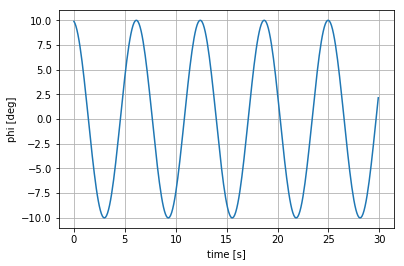

In [7]:
dt = 0.1
ts = np.arange(0,30,dt)

g=9.81
A=1
C=1
phi1d=0.0          # initial velocity
phi=np.deg2rad(10) # initial roll angle

phis=[]
for n in range(len(ts)):
    
    phi2d = -C*phi/A
    phi1d = phi1d + phi2d*dt
    phi = phi + phi1d*dt
    phis.append(phi)
    
fig,ax=plt.subplots()
ax.plot(ts,np.rad2deg(phis));
ax.set_xlabel('time [s]')
ax.set_ylabel('phi [deg]');
ax.grid(True)

In [8]:
#collapse

from matplotlib.patches import Rectangle
from matplotlib import transforms

def plot_ship(ax, angle):
    beam=1
    height=0.5
    ship = Rectangle(xy=(-beam/2,-height/2),width=1,height=0.5)
    
    t2 = transforms.Affine2D().rotate_deg(-np.rad2deg(angle)) + ax.transData
    ship.set_transform(t2)
    
    ax.add_patch(ship)
    ax.axis('equal')
    xlim=1.3*beam/2*np.array([-1,1])
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    
    ax.plot(xlim,[0,0],'b-');

def plot_roll(ts,phis):
    def plot(t=0.0):
        
        index=np.argmin(np.abs(ts-t))
        phi = phis[index]
        fig,ax=plt.subplots()
        plot_ship(ax=ax,angle=phi)
        
    return plot
    
interactive_plot = interactive(plot_roll(ts=ts, phis=phis), t=(ts[0],ts[-1],dt))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='t', max=29.900000000000002), Output(layout=Layout(he…

This is however not a damped motions as the motion does not decay. In order to get the decay one must also include a damping term $B$:
$$
A\cdot\ddot{\phi} + B\cdot\dot{\phi} + C\cdot\phi = 0
$$

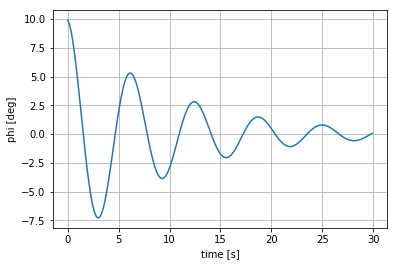

In [9]:
B=0.2
phi1d=0.0          # initial velocity
phi=np.deg2rad(10) # initial roll angle

phis=[]
for n in range(len(ts)):
    
    phi2d = (-C*phi - B*phi1d)/A
    phi1d = phi1d + phi2d*dt
    phi = phi + phi1d*dt
    phis.append(phi)
    
fig,ax=plt.subplots()
ax.plot(ts,np.rad2deg(phis));
ax.set_xlabel('time [s]')
ax.set_ylabel('phi [deg]');
ax.grid(True)

In [10]:
#collapse

from matplotlib.patches import Rectangle
from matplotlib import transforms

def plot_ship(ax, angle):
    beam=1
    height=0.5
    ship = Rectangle(xy=(-beam/2,-height/2),width=1,height=0.5)
    
    t2 = transforms.Affine2D().rotate_deg(-np.rad2deg(angle)) + ax.transData
    ship.set_transform(t2)
    
    ax.add_patch(ship)
    ax.axis('equal')
    xlim=1.3*beam/2*np.array([-1,1])
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    
    ax.plot(xlim,[0,0],'b-');

def plot_roll(ts,phis):
    def plot(t=0.0):
        
        index=np.argmin(np.abs(ts-t))
        phi = phis[index]
        fig,ax=plt.subplots()
        plot_ship(ax=ax,angle=phi)
        
    return plot
    
interactive_plot = interactive(plot_roll(ts=ts, phis=phis), t=(ts[0],ts[-1],dt))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='t', max=29.900000000000002), Output(layout=Layout(he…